---
### Analytic solution: Solving for lambda and Y

An optimisation using already-built python optimisation library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a1 = 23
a2 = 15
a3 = 10.5
a4 = 8.0
a5 = 5.5
a6 = 1.4
k1 = 0.10
k2 = 0.08
k3 = 0.08
k4 = 0.07
k5 = 0.07
k6 = 0.05
N = 100
b_min = 500
b_max = 1000
b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)
# try different IC's
# try even or odd

### Softmax transformation

In [ ]:
# Softmax transformation from u1, u2 -> theta1, theta2, theta3 (LogSumExp)
from scipy.special import logsumexp
def softmax_partition(u):
    u1, u2, u3, u4, u5 = u
    u = np.clip(u, -500, 500)
    logZ = logsumexp([u1, u2, u3, u4, u5, 0.0])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(u2 - logZ)
    theta3 = np.exp(u3 - logZ)
    theta4 = np.exp(u4 - logZ)
    theta5 = np.exp(u5 - logZ)
    theta6 = np.exp(-logZ)
    return theta1, theta2, theta3, theta4, theta5, theta6

def objective_softmax(u, b_val, alpha=1e-1):
    try:
        theta1, theta2, theta3, theta4, theta5, theta6 = softmax_partition(u)
        if theta1 < 1e-5:
            return np.inf
        term_Y1 = (a1 * theta2) / (b_val * theta1) + k1 - 1
        Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
        term_Y2 = (a2 * theta3) / (b_val * theta1) + k2 - (1 - Y1)
        Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
        term_Y3 = (a3 * theta4) / (b_val * theta1) + k3 - (1 - Y1 - Y2)
        Y3 = 0.5 * (np.sqrt(term_Y3**2 + 4 * (1 - Y1 - Y2) * k3) - term_Y3)
        term_Y4 = (a4 * theta5) / (b_val * theta1) + k4 - (1 - Y1 - Y2 - Y3)
        Y4 = 0.5 * (np.sqrt(term_Y4**2 + 4 * (1 - Y1 - Y2 - Y3) * k4) - term_Y4)
        term_Y5 = (a5 * theta6) / (b_val * theta1) + k5 - (1 - Y1 - Y2 - Y3 - Y4)
        Y5 = 0.5 * (np.sqrt(term_Y5**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4) * k5) - term_Y5)

        if any(np.isnan([Y1, Y2, Y3, Y4, Y5])):
            return np.inf

        Y6 = (a5 * theta6 / b_val) * (Y5 / (k5 + Y5))
        # regularization
        reg = alpha * np.sum(u**2)
        return -b_val * Y6 + reg
    except Exception as e:
        print("Error in objective:", e)
        return np.inf

def optimize_for_b_softmax(b_val, trials=1):
    best_result = None
    for _ in range(trials):
        u0 = np.random.normal(0, 0.5, size=5)
        '''result = minimize(lambda u: objective_softmax(u, b_val),
                          u0,
                          method='Nelder-Mead',
                          options={'maxiter': 1000, 'fatol': 1e-8})'''
        # Nelder-Mead is dependent on the initial conditions
        result = minimize(lambda u: objective_softmax(u, b_val),
                          u0,
                          method='L-BFGS-B',  # Switch to gradient-based method
                          options={'maxiter': 1000, 'fatol': 1e-8})
        if result.success:
            u_opt = result.x
            theta1, theta2, theta3, theta4, theta5, theta6 = softmax_partition(u_opt)
            if theta1 < 1e-5:
                continue

            term_Y1 = (a1 * theta2) / (b_val * theta1) + k1 - 1
            Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
            term_Y2 = (a2 * theta3) / (b_val * theta1) + k2 - (1 - Y1)
            Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
            term_Y3 = (a3 * theta4) / (b_val * theta1) + k3 - (1 - Y1 - Y2)
            Y3 = 0.5 * (np.sqrt(term_Y3**2 + 4 * (1 - Y1 - Y2) * k3) - term_Y3)
            term_Y4 = (a4 * theta5) / (b_val * theta1) + k4 - (1 - Y1 - Y2 - Y3)
            Y4 = 0.5 * (np.sqrt(term_Y4**2 + 4 * (1 - Y1 - Y2 - Y3) * k4) - term_Y4)
            term_Y5 = (a5 * theta6) / (b_val * theta1) + k5 - (1 - Y1 - Y2 - Y3 - Y4)
            Y5 = 0.5 * (np.sqrt(term_Y5**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4) * k5) - term_Y5)
            Y6 = (a5 * theta6 / b_val) * (Y5 / (k5 + Y5))
            Y7 = (theta2 / theta1) * Y6
            Y8 = (theta3 / theta1) * Y6
            Y9 = (theta4 / theta1) * Y6
            Y10 = (theta5 / theta1) * Y6
            Y11 = (theta6 / theta1) * Y6

            lambda_val = b_val * Y6
            r_denom = ((k1 + Y1) / (a1 * Y7)) + ((k2 + Y2) / (a2 * Y8)) + ((k3 + Y3) / (a3 * Y9)) + ((k4 + Y4) / (a4 * Y10)) + ((k5 + Y5) / (a5 * Y11))
            r_avg = 1 / r_denom if r_denom != 0 else np.nan

            best_result = [b_val,
                           [theta1, theta2, theta3, theta4, theta5, theta6],
                           [Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8, Y9, Y10, Y11],
                           lambda_val,
                           r_avg]
            break
    if best_result is None:
        print(f"Optimization failed for b = {b_val}")
    return best_result

# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = [r for r in results if r is not None]
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

# Organize into arrays
b_arr       = np.array([r[0] for r in results])
theta_arr   = np.array([r[1] for r in results])
Y_arr       = np.array([r[2] for r in results])
lambda_arr  = np.array([r[3] for r in results])
r_avg_arr   = np.array([r[4] for r in results])

theta1_arr, theta2_arr, theta3_arr, theta4_arr, theta5_arr, theta6_arr = theta_arr.T
Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr, Y6_arr, Y7_arr, Y8_arr, Y9_arr, Y10_arr, Y11_arr = Y_arr.T

Optimization completed in 0.76 seconds.


### Line fitting

In [ ]:
from scipy.stats import linregress
# Perform linear regression
def linear_fit(x, y):
  slope, intercept, r_value, p_value, std_err = linregress(x, y)
  x_fit = np.linspace(min(x), max(x), 201)
  y_fit = slope * x_fit + intercept
  r_squared = r_value**2
  return [x_fit, y_fit, r_squared, slope, intercept]

# lambda vs. b (linear)
b_lambda_fit = linear_fit(b_arr, lambda_arr)
Y3_lambda_fit = linear_fit(Y3_arr, lambda_arr)
Y4_lambda_fit = linear_fit(Y4_arr, lambda_arr)
Y5_lambda_fit = linear_fit(Y5_arr, lambda_arr)

### Plot the result

/tmp/ipython-input-34-3454706999.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # show the label


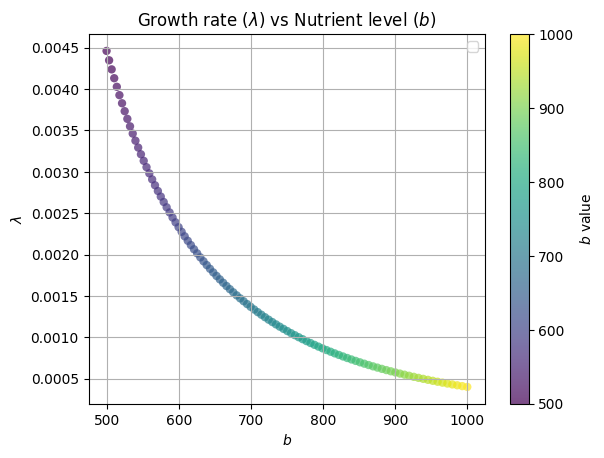

/tmp/ipython-input-34-3454706999.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


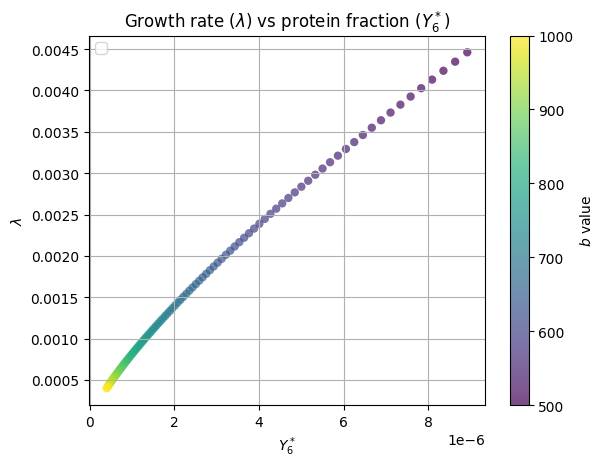

/tmp/ipython-input-34-3454706999.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


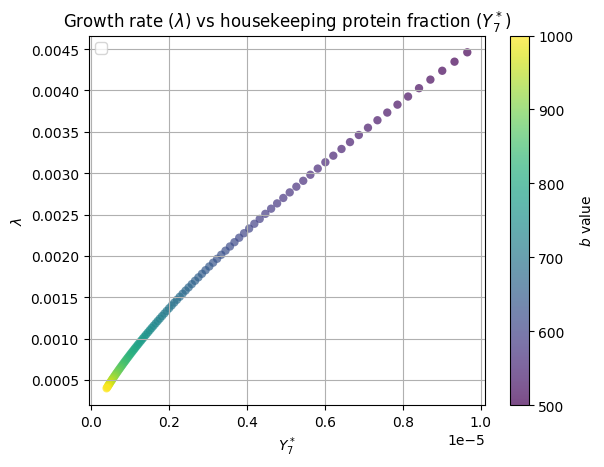

/tmp/ipython-input-34-3454706999.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


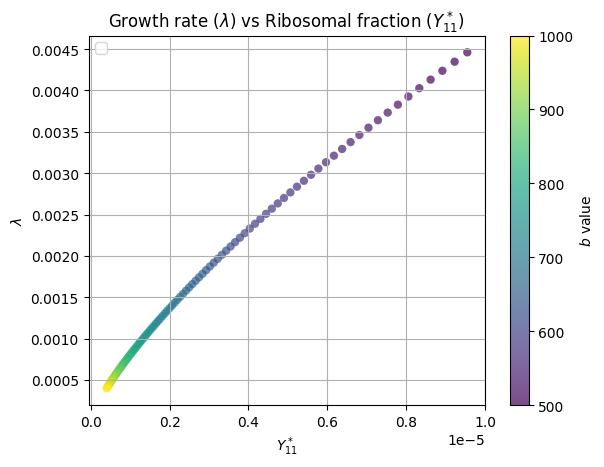

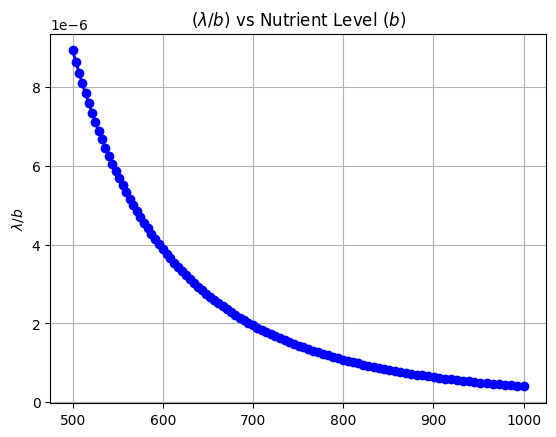

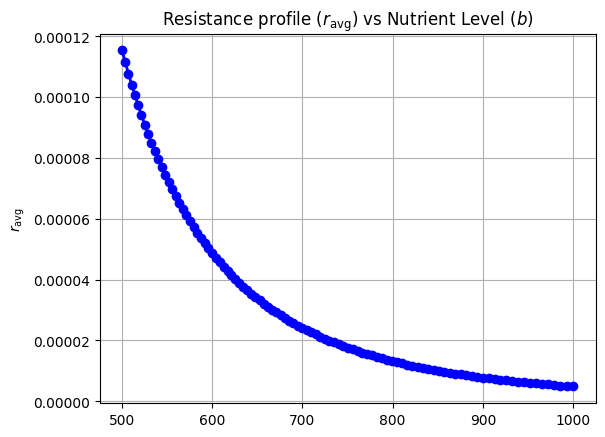

"# Growth rate to (truncated) ribosomal fraction (Y5)\nplt.figure()\nplt.plot(Y5_trunc, lambda_trunc, lw=2, label=r'', marker='o', color='blue')\nplt.plot(Y5_lambda_trunc_fit[0], Y5_lambda_trunc_fit[1], '-', label=f'Linear fit: y = {Y5_lambda_trunc_fit[3]:.3f}x + {Y5_lambda_trunc_fit[4]:.3f}\n$R^2$ = {Y5_lambda_trunc_fit[2]:.4f}', color='red') # line of best fit\nplt.xlabel(r'$Y_5^*$')\nplt.ylabel(r'$\\lambda$')\nplt.title(r'Growth rate ($\\lambda$) vs (Truncated) Ribosomal fraction ($Y_5^* > 0.10$)')\nplt.grid(True)\nplt.legend()\nplt.show()"

In [ ]:
'''for i in range(len(Y1_arr)):
    print(Y1_arr[i] + Y2_arr[i] + Y3_arr[i] + Y4_arr[i] + Y5_arr[i] + Y6_arr[i] + Y7_arr[i] + Y8_arr[i] + Y9_arr[i] + Y10_arr[i] + Y11_arr[i])'''

# Growth rate to nutrient level (b)
plt.figure()
# plt.plot(b_lambda_fit[0], b_lambda_fit[1], '-', label=f'Linear fit: y = {b_lambda_fit[3]:.3f}x + {b_lambda_fit[4]:.3f}\n$R^2$ = {b_lambda_fit[2]:.4f}', color='red') # line of best fit
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend() # show the label
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y3)
plt.figure()
scatter = plt.scatter(Y6_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_6^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_6^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein fraction (Y4) -> this should be constant
plt.figure()
scatter = plt.scatter(Y7_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_7^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs housekeeping protein fraction ($Y_7^*$)')
plt.grid(True)
# plt.xlim(0, 0.001)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y5) with color code
plt.figure()
scatter = plt.scatter(Y11_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value') # indicator of b value
plt.xlabel(r'$Y_{11}^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_{11}^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Yield per unit input
plt.figure()
plt.plot(b_arr, lambda_arr / b_arr, lw=2, label=r'', marker='o', color='blue')
plt.ylabel(r'$\lambda / b$')
plt.title(r'($\lambda / b$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.show()

# Efficiency and Tradeoffs
plt.figure()
plt.plot(b_arr, r_avg_arr, lw=2, label=r'', marker='o', color='blue')
plt.ylabel(r'$r_\text{avg}$')
plt.title(r'Resistance profile ($r_\text{avg}$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.show()

'''# Growth rate to (truncated) ribosomal fraction (Y5)
plt.figure()
plt.plot(Y5_trunc, lambda_trunc, lw=2, label=r'', marker='o', color='blue')
plt.plot(Y5_lambda_trunc_fit[0], Y5_lambda_trunc_fit[1], '-', label=f'Linear fit: y = {Y5_lambda_trunc_fit[3]:.3f}x + {Y5_lambda_trunc_fit[4]:.3f}\n$R^2$ = {Y5_lambda_trunc_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_5^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs (Truncated) Ribosomal fraction ($Y_5^* > 0.10$)')
plt.grid(True)
plt.legend()
plt.show()'''

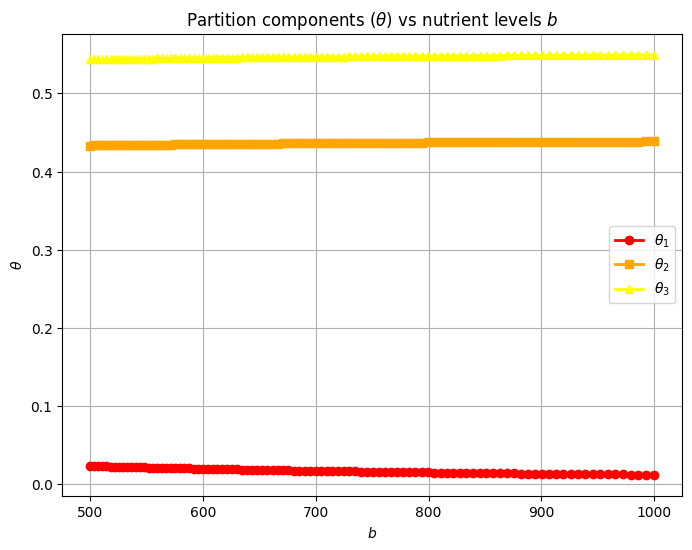

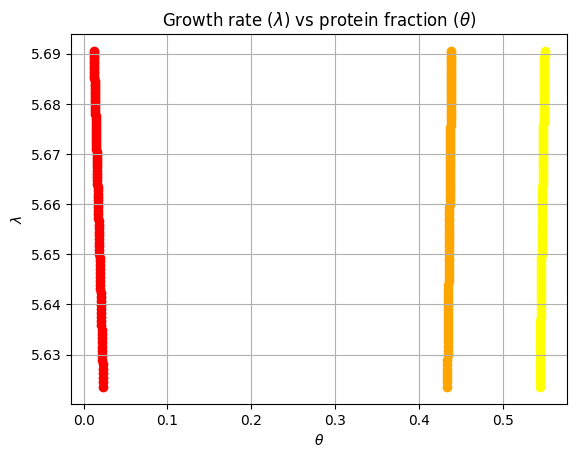

,Nutrient level,Growth rate,theta1,theta2,theta3
0,500.000000,5.623562,0.023314,0.433302,0.543384
1,503.513027,5.624476,0.023169,0.433368,0.543463
2,507.050737,5.625386,0.023004,0.433469,0.543527
3,510.613303,5.626289,0.022857,0.433518,0.543625
4,514.200900,5.627186,0.022707,0.433589,0.543704
...,...,...,...,...,...
95,972.382584,5.688624,0.012371,0.438296,0.549333
96,979.214597,5.689115,0.012288,0.438375,0.549336
97,986.094612,5.689603,0.012206,0.438412,0.549382
98,993.022967,5.690088,0.012124,0.438446,0.549430


'\n# numerical experiment\nprint(theta2_arr / np.sqrt(b_arr)) # beta\nprint(theta3_arr / b_arr) # gamma\nprint(theta2_arr / theta3_arr * np.sqrt(b_arr))\n'

In [ ]:
# Partition components to nutrient levels b
plt.figure(figsize=(8,6)) # set size of the graph (call before plt.plot)
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='s', color='orange')
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='^', color='yellow')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='red')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='orange')
plt.scatter(theta3_arr, lambda_arr, label=r'$\theta_3$', c='yellow')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)')
plt.grid(True)
plt.show()

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "theta1": theta1_arr,
    "theta2": theta2_arr,
    "theta3": theta3_arr,
})
display(df)

'''
# numerical experiment
print(theta2_arr / np.sqrt(b_arr)) # beta
print(theta3_arr / b_arr) # gamma
print(theta2_arr / theta3_arr * np.sqrt(b_arr))
'''

### Small and Large Molecules
The small molecules include metabolites and precursors. Large molecules include different types of proteins.

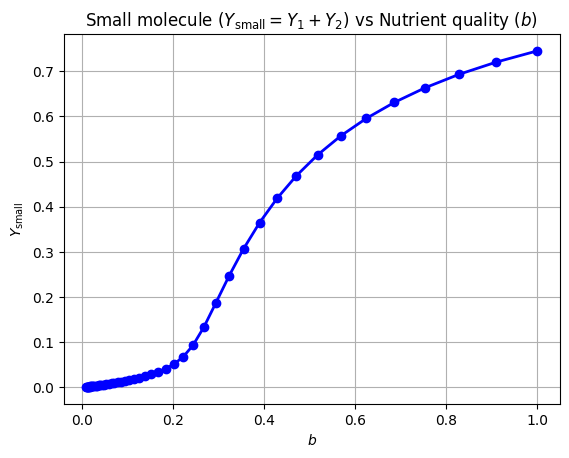

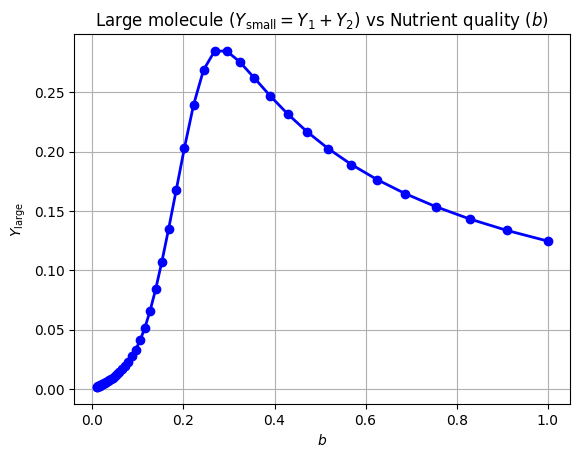

,Nutrient level,Growth rate,Small molecule fraction,Large molecule fraction
0,0.010000,0.001406,0.001143,0.001653
1,0.010985,0.001546,0.001259,0.001828
2,0.012068,0.001701,0.001387,0.002022
3,0.013257,0.001871,0.001529,0.002238
4,0.014563,0.002059,0.001685,0.002479
5,0.015999,0.002266,0.001858,0.002749
6,0.017575,0.002494,0.002050,0.003051
7,0.019307,0.002745,0.002263,0.003391
8,0.021210,0.003023,0.002499,0.003773
9,0.023300,0.003329,0.002761,0.004204


In [ ]:
# Discuss different molecdule sizes
small_mol_arr = Y1_arr + Y2_arr
large_mol_arr = Y3_arr + Y4_arr + Y5_arr

# Small molecule (metabolites and a.a.'s) fraction (Y1 + Y2) to b
plt.figure()
plt.plot(b_arr, small_mol_arr, lw=2, label=r'', marker='o', color='blue')
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{small}$')
plt.title(r'Small molecule ($Y_\text{small} = Y_1 + Y_2$) vs Nutrient quality ($b$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
plt.plot(b_arr, large_mol_arr, lw=2, label=r'', marker='o', color='blue')
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{large}$')
plt.title(r'Large molecule ($Y_\text{small} = Y_1 + Y_2$) vs Nutrient quality ($b$)')
plt.grid(True)
plt.show()

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Small molecule fraction": small_mol_arr,
    "Large molecule fraction": large_mol_arr,
})
display(df)

## Heat Map

In [ ]:
b_target = 0.1

# ==== 重新優化這個 b_target 對應的最佳點 ====
opt_result = minimize(lambda u: objective_softmax(u, b_target), [0.0, 0.0], method='BFGS')

if opt_result.success:
    u1_opt, u2_opt = opt_result.x
    lambda_opt = -objective_softmax([u1_opt, u2_opt], b_target)
    theta1_opt, theta2_opt, theta3_opt = softmax_partition([u1_opt, u2_opt])
else:
    u1_opt = u2_opt = lambda_opt = theta1_opt = theta2_opt = theta3_opt = np.nan

# ==== 建立網格 ====
u1_vals = np.linspace(-5, 5, 1000)
u2_vals = np.linspace(-5, 5, 1000)
U1, U2 = np.meshgrid(u1_vals, u2_vals)
Z = np.empty_like(U1)

# ==== 計算熱圖用的 -λ 值 ====
for i in range(U1.shape[0]):
    for j in range(U1.shape[1]):
        Z[i, j] = - objective_softmax([U1[i, j], U2[i, j]], b_target)

# ==== 畫出熱圖 ====
plt.figure(figsize=(6,4.5))
cp = plt.contourf(U1, U2, Z, levels=50, cmap='viridis')
plt.colorbar(cp, label=r'Objective: $\lambda$')
plt.scatter(u1_opt, u2_opt, color='red', marker='o', s=80, label='Optimal point')

# ==== 標註最佳點資訊 ====
textstr = '\n'.join((
    r'$\lambda^* = %.4f$' % lambda_opt,
    r'$\theta_1^* = %.4f$' % theta1_opt,
    r'$\theta_2^* = %.4f$' % theta2_opt,
    r'$\theta_3^* = %.4f$' % theta3_opt,
))
plt.annotate(textstr,
             xy=(u1_opt, u2_opt),
             xytext=(u1_opt+0.5, u2_opt+0.5),
             fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.9),
             arrowprops=dict(arrowstyle='->', lw=1.5))

plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}')
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.legend()
plt.tight_layout()
plt.show()

Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack 

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Streaming output truncated to the last 5000 lines.
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 2)
Error in objective: not enough values to unpack (expected 5, got 

KeyboardInterrupt: 

## Code Dump

Using scipy.optimize import minimize

/tmp/ipython-input-35-1166801310.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


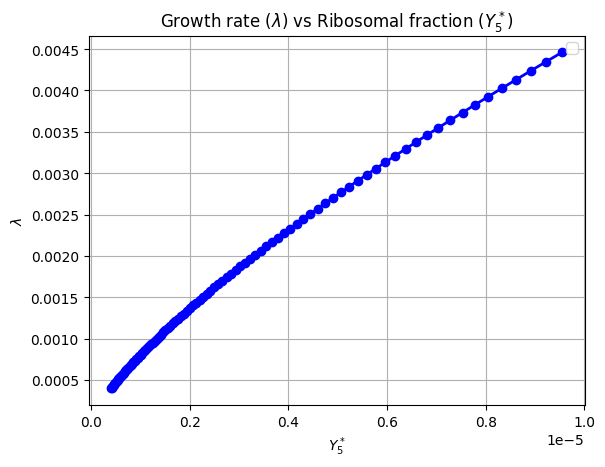

Finished in 1.70 seconds.


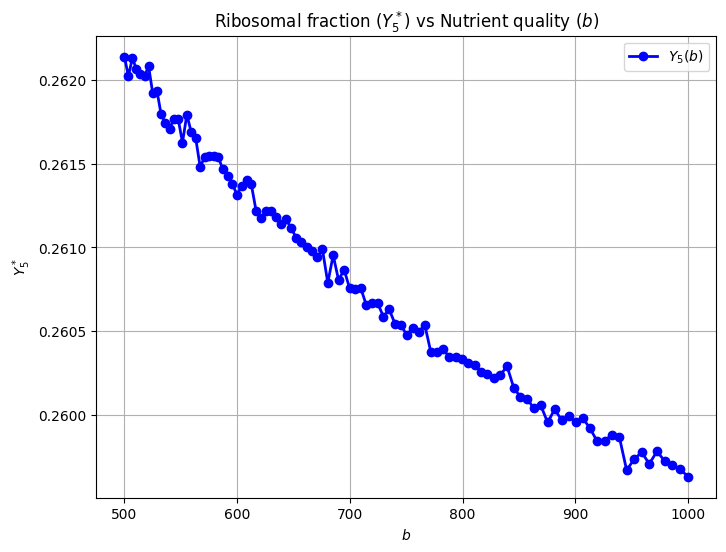

In [ ]:
# Growth rate to ribosomal fraction (Y5)
plt.figure()
plt.plot(Y11_arr, lambda_arr, lw=2, label=r'', marker='o', color='blue')
plt.xlabel(r'$Y_5^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_5^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Function to optimize
def optimize_for_b(b_val):
    def objective(t):
        t1, t3 = t
        if t1 + t3 >= 1 or t1 <= 0 or t3 <= 0:
            return np.inf
        t2 = 1 - t1 - t3
        try:
            term_Y1 = (a1 * t2) / (b_val * t1) + k1 - 1
            Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
            term_Y2 = (a2 * t3) / (b_val * t1) + k2 - (1 - Y1)
            Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
            if np.isnan(Y1) or np.isnan(Y2) or Y1 < 0 or Y2 < 0:
                return np.inf
            Y3 = (a2 * t3 / b_val) * (Y2 / (k2 + Y2))
            return -b_val * Y3
        except:
            return np.inf

    constraints = [{'type': 'ineq', 'fun': lambda t: 1 - t[0] - t[1]}]
    bounds = [(1e-6, 1.0), (1e-6, 1.0)]
    result = minimize(objective, [0.3, 0.3], method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        t1, t3 = result.x
        t2 = 1 - t1 - t3
        term_Y1 = (a1 * t2) / (b_val * t1) + k1 - 1
        Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
        term_Y2 = (a2 * t3) / (b_val * t1) + k2 - (1 - Y1)
        Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
        Y3 = (a2 * t3 / b_val) * (Y2 / (k2 + Y2))
        Y4 = (a2 * t2 * t3 / (b_val * t1)) * (Y2 / (k2 + Y2))
        Y5 = (a2 * t3**2 / (b_val * t1)) * (Y2 / (k2 + Y2))
        lambda_val = b_val * Y3
        r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))
        r_avg = 1 / r_denom if r_denom != 0 else np.nan
        return [b_val, [t1, t2, t3], [Y1, Y2, Y3, Y4, Y5], lambda_val, r_avg]
    return None

# Run in parallel
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b)(b) for b in b_vals)
results = [res for res in results if res is not None]
print(f"Finished in {time.time() - start:.2f} seconds.")

# Save to arrays
b_arr = np.array([row[0] for row in results])
theta_arr = np.array([row[1] for row in results])
Y_arr = np.array([row[2] for row in results])
lambda_arr = np.array([row[3] for row in results])
r_avg_arr = np.array([row[4] for row in results])

theta1_arr, theta2_arr, theta3_arr = theta_arr.T
Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr = Y_arr.T

# Put in DataFrame
'''df = pd.DataFrame({
    "b": b_arr,
    "lambda": lambda_arr,
    "theta1": theta1_arr,
    "theta2": theta2_arr,
    "theta3": theta3_arr,
    "Y1": Y1_arr,
    "Y2": Y2_arr,
    "Y3": Y3_arr,
    "Y4": Y4_arr,
    "Y5": Y5_arr,
    "r_avg": r_avg_arr
})
display(df)'''

# Ribosomal fraction (Y5) to b
plt.figure(figsize=(8,6)) # set size of the graph (call before plt.plot)
plt.plot(b_arr, Y5_arr, lw=2, label=r'$Y_5(b)$', marker='o', color='blue')
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_5^*$')
plt.title(r'Ribosomal fraction ($Y_5^*$) vs Nutrient quality ($b$)')
plt.grid(True)
plt.legend()
plt.show()